# Regression Engine to predict Arrival Delay

In this notebook we are going to buils a model to predict the delay time of flights.

Table of contents:

1. [Import relevant libraries](#Libraries)
2. [Load files](#Load)
3. [Preview files](#Preview)
5. [Data exploration and transformation](#Exploration)
6. [Target distribution](#Target)
7. [Outliers](#Outliers)
8. [Correlations](#Correlations)
9. [Model training](#Model)
10. [Test set predictions](#Predictions)
11. [Creating a submission file](#Submission)
12. [Tips to improve model performance](#Tips)

<a name = "Libraries"></a>
## 1. Import relevant libraries

In [30]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Performance metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name = "Load"></a>
## 2. Load files

In [32]:
# Path to your file within Google Drive
file_path = '/content/drive/MyDrive/PFE/flights.csv'

# Read the file using pandas
df = pd.read_csv(file_path)

<a name = "Preview"></a>
## 3. Preview files

In [33]:
df.head()

,aircraft,date,from,to,flight,flight_time,scheduled_time_departure,actual_time_departure,scheduled_time_arrival,status,actual_time_arrival,from_city,to_city,rounded_hour,airport,delay_time
0,se-rrb,2024-03-20,arn,szg,D84471,2024-03-20T01:50:00.000+01:00,2024-03-20T10:15:00.000+01:00,2024-03-20T10:28:00.000+01:00,2024-03-20T12:25:00.000+01:00,On Time,2024-03-20T12:18:00.000+01:00,stockholm,salzburg,2024-03-20T12:00:00.000+01:00,szg,-7.0
1,se-rrb,2024-03-03,ume,arn,D84014,2024-03-03T00:50:00.000+01:00,2024-03-03T17:45:00.000+01:00,2024-03-03T17:54:00.000+01:00,2024-03-03T18:50:00.000+01:00,On Time,2024-03-03T18:44:00.000+01:00,umea,stockholm,2024-03-03T19:00:00.000+01:00,arn,-6.0
2,se-rrb,2023-12-03,arn,lla,D84039,2023-12-03T01:07:00.000+01:00,2023-12-03T13:05:00.000+01:00,2023-12-03T13:18:00.000+01:00,2023-12-03T14:25:00.000+01:00,On Time,2023-12-03T14:24:00.000+01:00,stockholm,lulea,2023-12-03T14:00:00.000+01:00,lla,-1.0
3,se-rrb,2023-12-03,lla,arn,D84036,2023-12-03T01:04:00.000+01:00,2023-12-03T10:15:00.000+01:00,2023-12-03T10:31:00.000+01:00,2023-12-03T11:35:00.000+01:00,On Time,2023-12-03T11:35:00.000+01:00,lulea,stockholm,2023-12-03T12:00:00.000+01:00,arn,0.0
4,se-rrb,2023-08-11,pmi,arn,D84214,2023-08-11T03:13:00.000+01:00,2023-08-11T20:05:00.000+01:00,2023-08-11T20:05:00.000+01:00,2023-08-11T23:45:00.000+01:00,On Time,2023-08-11T23:18:00.000+01:00,palma de mallorca,stockholm,2023-08-11T00:00:00.000+01:00,arn,-27.0


<a name = "Exploration"></a>
## 5. Data exploration and transformation

Axes(0.125,0.11;0.698618x0.77)


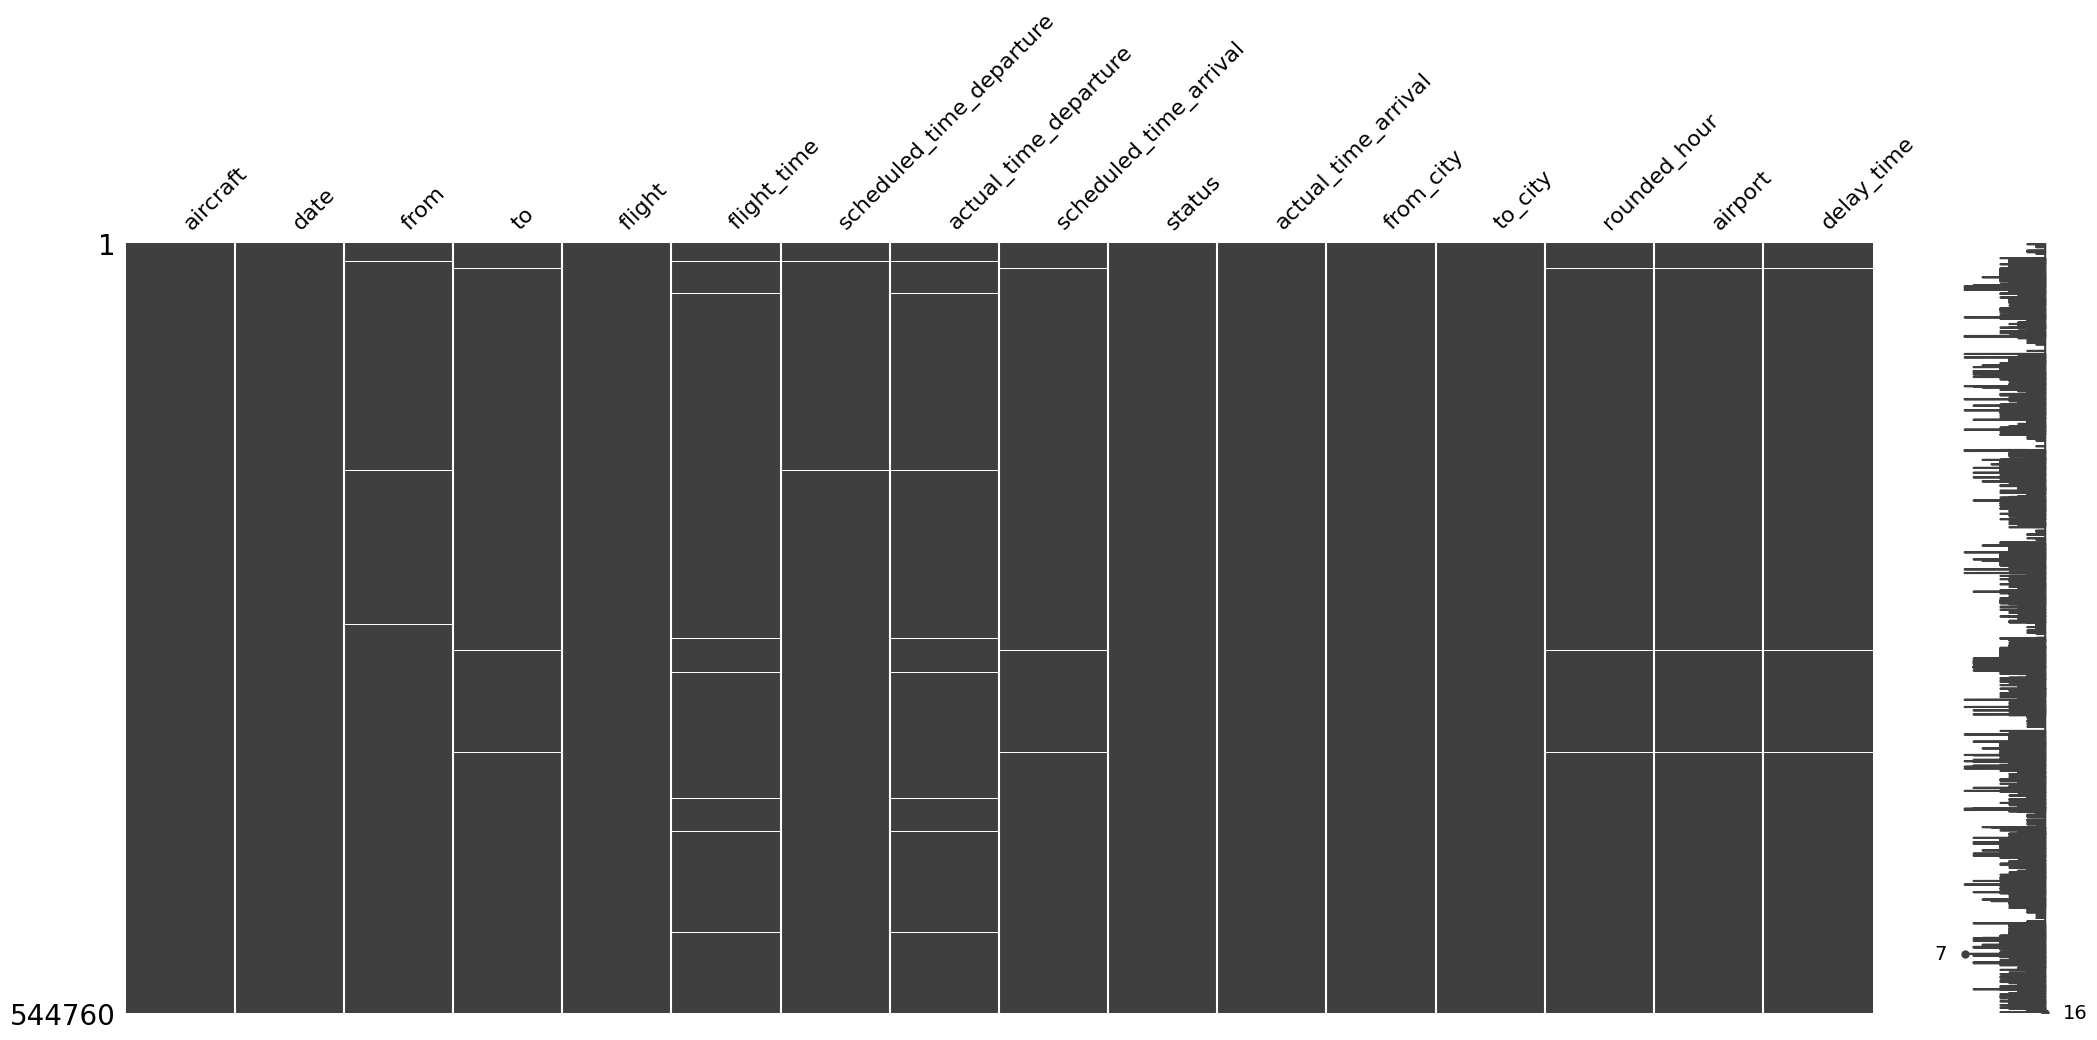

In [34]:
print(msno.matrix(df))

In [35]:
df.dropna(inplace=True)

In [36]:
# Check for any missing values
df.isnull().sum().any()

False

In [37]:
df['status'] = df['status'].map({"On Time": 0, "Delayed": 1})

# Convert datetime string column to datetime type
df['flight_time'] = pd.to_datetime(df['flight_time']).dt.tz_localize(None)
df['scheduled_time_departure'] = pd.to_datetime(df['scheduled_time_departure']).dt.tz_localize(None)
df['actual_time_departure'] = pd.to_datetime(df['actual_time_departure']).dt.tz_localize(None)
df['scheduled_time_arrival'] = pd.to_datetime(df['scheduled_time_arrival']).dt.tz_localize(None)
df['actual_time_arrival'] = pd.to_datetime(df['actual_time_arrival']).dt.tz_localize(None)
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
df["status"] = df["status"].astype('int')

df["departure_delay"] = df["actual_time_departure"] - df["scheduled_time_departure"]
# Convert the departure delay to minutes
df['departure_delay'] = df['departure_delay'].dt.total_seconds() / 60

df["departure_delay_15"] = df["departure_delay"] > 15
df["departure_delay_15"] = df["departure_delay_15"].astype('int')

df = df[df['status']==1]



df["arrival_delay"] = df["actual_time_arrival"] - df["scheduled_time_arrival"]
# Convert the arrival delay to minutes
df['arrival_delay'] = df['arrival_delay'].dt.total_seconds() / 60


df['year'] = df['scheduled_time_arrival'].dt.year
df['month'] = df['scheduled_time_arrival'].dt.month
df['day'] = df['scheduled_time_arrival'].dt.day
df['hour'] = df['scheduled_time_arrival'].dt.hour
df['dayofweek'] = df['scheduled_time_arrival'].dt.dayofweek
df['quarter'] = df['scheduled_time_arrival'].dt.quarter
df['is_year_start'] = df['scheduled_time_arrival'].dt.is_year_start
df['is_year_end'] = df['scheduled_time_arrival'].dt.is_year_end

df["is_year_start"] = df["is_year_start"].astype('int')
df["is_year_end"] = df["is_year_end"].astype('int')

cols = ['flight', 'aircraft', 'from', 'to', 'from_city',
       'to_city', 'year', 'month', 'day', 'hour', 'dayofweek', 'quarter', 'is_year_start', 'is_year_end', 'departure_delay', 'arrival_delay']

df = df[cols]

<ipython-input-37-557b9867a39e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival_delay"] = df["actual_time_arrival"] - df["scheduled_time_arrival"]
<ipython-input-37-557b9867a39e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arrival_delay'] = df['arrival_delay'].dt.total_seconds() / 60
<ipython-input-37-557b9867a39e>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [38]:
# encode categorical data into numeric values
labelEncoder = LabelEncoder()
df["flight"] = labelEncoder.fit_transform(df["flight"])
df["aircraft"] = labelEncoder.fit_transform(df["aircraft"])
df["from"] = labelEncoder.fit_transform(df["from"])
df["to"] = labelEncoder.fit_transform(df["to"])
df["from_city"] = labelEncoder.fit_transform(df["from_city"])
df["to_city"] = labelEncoder.fit_transform(df["to_city"])

In [39]:
# Show the first few rows of the DataFrame
df.head()

,flight,aircraft,from,to,from_city,to_city,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,departure_delay,arrival_delay
20,7580,163,1004,195,919,211,2023,4,11,22,1,2,0,0,36.0,17.0
23,8618,274,917,1446,901,1365,2023,12,27,21,2,4,0,0,58.0,33.0
48,30342,458,76,219,1480,240,2023,11,1,18,2,4,0,0,41.0,25.0
50,30361,458,1290,77,1175,1479,2023,9,13,15,2,3,0,0,72.0,46.0
51,30565,458,267,77,1188,1479,2023,6,6,21,1,2,0,0,128.0,107.0


In [40]:
# Check statistical summaries of the dataset
df.describe()

,flight,aircraft,from,to,from_city,to_city,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,departure_delay,arrival_delay
count,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000,101813.000000
mean,21176.435426,228.003438,864.734484,878.689048,854.930726,862.963983,2023.255213,6.467838,15.895367,14.167238,3.052754,2.494750,0.002180,0.002259,37.977282,92.969434
std,11674.685337,141.332182,534.675213,536.616026,496.726716,495.477334,0.435983,3.319132,8.812826,5.977343,1.980540,1.069531,0.046645,0.047476,238.264789,217.704886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1435.000000,16.000000
25%,11242.000000,103.000000,391.000000,400.000000,397.000000,410.000000,2023.000000,4.000000,8.000000,11.000000,1.000000,2.000000,0.000000,0.000000,40.000000,24.000000
50%,21977.000000,211.000000,864.000000,896.000000,893.000000,900.000000,2023.000000,7.000000,16.000000,15.000000,3.000000,3.000000,0.000000,0.000000,57.000000,39.000000
75%,30550.000000,364.000000,1321.000000,1325.000000,1275.000000,1288.000000,2024.000000,9.000000,23.000000,19.000000,5.000000,3.000000,0.000000,0.000000,87.000000,72.000000
max,42284.000000,460.000000,1856.000000,1858.000000,1745.000000,1745.000000,2024.000000,12.000000,31.000000,23.000000,6.000000,4.000000,1.000000,1.000000,1421.000000,1439.000000


In [41]:
df.dtypes

flight               int64
aircraft             int64
from                 int64
to                   int64
from_city            int64
to_city              int64
year                 int32
month                int32
day                  int32
hour                 int32
dayofweek            int32
quarter              int32
is_year_start        int64
is_year_end          int64
departure_delay    float64
arrival_delay      float64
dtype: object

<a name = "Target"></a>
## 6. Target variable distribution

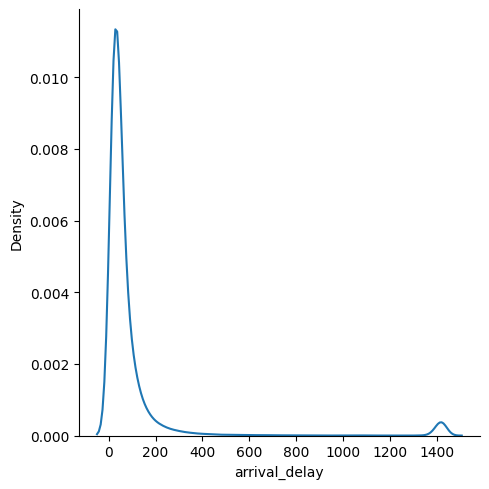

In [42]:
sns.displot(df, x="arrival_delay", kind="kde")

<a name = "Model"></a>
## 9. Model training

In [43]:
X = df.loc[:, df.columns != "arrival_delay"]
y = np.array(df.loc[:, df.columns == "arrival_delay"]["arrival_delay"])

In [44]:
print(f"\nDataset shape: {df.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"features_train shape: {X_train.shape} | features_test shape: {X_test.shape}")
print(f"labels_train shape: {y_train.shape} | labels_test shape: {y_test.shape}")


Dataset shape: (101813, 16)
features_train shape: (81450, 15) | features_test shape: (20363, 15)
labels_train shape: (81450,) | labels_test shape: (20363,)


In [45]:
def print_metrics(labels_test, model_pred, regressor_name):

    mse = mean_squared_error(labels_test, model_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels_test, model_pred)
    r2 = r2_score(labels_test, model_pred)

    print(f"MSE      : {mse}", end="\n\n")
    print(f"RMSE     : {rmse}", end="\n\n")
    print(f"MAE      : {mae}", end="\n\n")
    print(f"R2 Score : {r2}", end="\n\n")

##Linear Regression

In [46]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [47]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "LinearRegression")

MSE      : 40074.99490286875

RMSE     : 200.18739946077713

MAE      : 102.20587276109111

R2 Score : 0.18094298658104235



## Decision Tree Regressor

In [48]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [49]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "DecisionTreeRegressor")

MSE      : 9000.539728920101

RMSE     : 94.8711743835824

MAE      : 18.541128517409025

R2 Score : 0.8160460105510767



## XGBoost

In [50]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [51]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "GradientBoostingRegressor")

MSE      : 4675.429655997681

RMSE     : 68.3771135395293

MAE      : 16.840650544894448

R2 Score : 0.9044430708032914



## Random Forest

In [52]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [53]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "RandomForestRegressor")

MSE      : 3954.4730805556205

RMSE     : 62.88460129917038

MAE      : 14.227508806822833

R2 Score : 0.9191780580669845



## To Do
- Fine tuning
- Model validation
